<a href="https://colab.research.google.com/github/ach224/Prediction_eligibilite_pret_bancaire/blob/Modelisation_A%C3%AFcha/Modelisation_Aicha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etape 3 : Modélisation

* Définir variable cible : Loan_Status
* Séparer train/test
* Tester plusieurs modèles (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting)
* Comparer performances (Accuracy, Precision, Recall, F1-score, ROC-AUC)

In [2]:
# Récupération du dernier dataframe
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/DATA SCIENCES/PROJET DATA SCIENCES/loan_prediction.csv')
df.head()

Mounted at /content/drive


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Traitement des valeurs manquantes
  # Colonnes numériques : remplacer par la médiane
for col in ['LoanAmount', 'Loan_Amount_Term']:
    df[col] = df[col].fillna(df[col].median())

  # Colonnes categorielle : remplacer par le mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    df[col] = df[col].fillna(df[col].mode()[0])

# Suppression de la colonne Loan_ID
df.drop('Loan_ID', axis=1, inplace=True)

# Encodage des variables
# Colonnes catégorielles à encoder
cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# One-Hot Encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Convertir la variable df['Dependents'] en int
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)
df['CoapplicantIncome'] = df['CoapplicantIncome'].astype(int)
df['LoanAmount'] = df['LoanAmount'].astype(int)
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(int)
df['Credit_History'] = df['Credit_History'].astype(int)

# Encoder Loan_Status
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Vérification
print(df['Loan_Status'].value_counts())
print(df.info())
df.head()

Loan_Status
1    422
0    192
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Dependents               614 non-null    int64
 1   ApplicantIncome          614 non-null    int64
 2   CoapplicantIncome        614 non-null    int64
 3   LoanAmount               614 non-null    int64
 4   Loan_Amount_Term         614 non-null    int64
 5   Credit_History           614 non-null    int64
 6   Loan_Status              614 non-null    int64
 7   Gender_Male              614 non-null    bool 
 8   Married_Yes              614 non-null    bool 
 9   Education_Not Graduate   614 non-null    bool 
 10  Self_Employed_Yes        614 non-null    bool 
 11  Property_Area_Semiurban  614 non-null    bool 
 12  Property_Area_Urban      614 non-null    bool 
dtypes: bool(6), int64(7)
memory usage: 37.3 KB
None


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0,128,360,1,1,True,False,False,False,False,True
1,1,4583,1508,128,360,1,0,True,True,False,False,False,False
2,0,3000,0,66,360,1,1,True,True,False,True,False,True
3,0,2583,2358,120,360,1,1,True,True,True,False,False,True
4,0,6000,0,141,360,1,1,True,False,False,False,False,True


Concernant les **valeurs aberrantes**, leur gestion sera vu au moment du choix du modèle, car selon le type de modèle, certains sont moins sensibles que d'autres. A titre d'exemple :
* Les modèles linéaires (ex. régression logistique, SVM) sont sensibles aux valeurs extrêmes,
* Les modèles basés sur des arbres (DecisionTree, RandomForest, XGBoost) le sont beaucoup moins.

Il en est de même pour la **normalisation**, étape qui dépend du type de modèle de machine learning choisi :
* Nécessaire pour les modèles sensibles à l’échelle des données (Régression logistique, SVM, KNN, Réseaux de neurones).
* Optionnelle pour les modèles basés sur les arbres (Arbre de décision, Random Forest, XGBoost), qui ne dépendent pas de l’échelle des variables.

## 1. Définir la variable cible

Nous savons que notre variable cible est ['Loan_Status'].


In [6]:
y = df['Loan_Status']
X = df.drop(columns = ['Loan_Status'])

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

X.head()

Shape de X: (614, 12)
Shape de y: (614,)


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0,128,360,1,True,False,False,False,False,True
1,1,4583,1508,128,360,1,True,True,False,False,False,False
2,0,3000,0,66,360,1,True,True,False,True,False,True
3,0,2583,2358,120,360,1,True,True,True,False,False,True
4,0,6000,0,141,360,1,True,False,False,False,False,True


## 2. Séparer les données train/test

Nous allons utiliser 80% des données pour l'entrainement (train) et les 20% restants pour le test.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,                    # Toutes les variables
    y,                    # Variable cible
    test_size = 0.2,      # 20% des données pour le test
    random_state = 42,    # pour la reproductibilité
    stratify = y          # Perme de garder le même ratio 0/1 dans les deux ensembles
)

# Vérification des dimensions
print("Dimension de X_train :", X_train.shape)
print("Dimension de y_train :", y_train.shape)
print("Dimension de X_test :", X_test.shape)
print("Dimension de y_test :", y_test.shape)

Dimension de X_train : (491, 12)
Dimension de y_train : (491,)
Dimension de X_test : (123, 12)
Dimension de y_test : (123,)


Détail des paramètres :    
| Paramètre         | Rôle                                                   | Pourquoi c’est important                                                              |
| ----------------- | ------------------------------------------------------ | ------------------------------------------------------------------------------------- |
| `test_size=0.2`   | Garde 20% du jeu pour tester                           | Assez pour une bonne évaluation                                                       |
| `random_state=42` | Fixe le tirage aléatoire                               | Pour obtenir les mêmes résultats à chaque exécution                                   |
| `stratify=y`      | Conserve le même équilibre de classes entre train/test | Indispensable car `Loan_Status` est déséquilibré (plus de prêts accordés que refusés) |


In [9]:
# Vérification de la répartition des 0/1 de la variable Loan_Status dans les deux groupes
print("Répartition dasn y_train :", y_train.value_counts(normalize=True))
print("\nRépartition dans y_test :", y_test.value_counts(normalize=True))

Répartition dasn y_train : Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64

Répartition dans y_test : Loan_Status
1    0.691057
0    0.308943
Name: proportion, dtype: float64


Les pourcentages de 0/1 sont quasi-identiques dans les deux groupes (test et train. Notre dataset est désormais prêt pour l'étape suivante.

## 3. Tester plusieurs modèles

Notre jeu de données présente les caractéristiques suivantes :    
* Variable cible binaire (Loan_Status) → problème de classification supervisée.
* Variables mixtes (numériques + catégorielles encodées).
* Taille du dataset moyenne (~600 lignes).
* Variables explicatives assez simples (revenus, statut, historique de crédit, etc.).

| Modèle                                     | Type / Famille                     | Points forts 💪                                                                                                | Points faibles ⚠️                                                                   | Besoin de normalisation 📏           | Sensibilité aux valeurs aberrantes ⚡       | Pourquoi l’essayer ici ?                                                    |
| :----------------------------------------- | :--------------------------------- | :------------------------------------------------------------------------------------------------------------- | :---------------------------------------------------------------------------------- | :----------------------------------- | :----------------------------------------- | :-------------------------------------------------------------------------- |
| **Régression Logistique**                  | Linéaire                           | - Simple, rapide et interprétable<br>- Fournit des probabilités<br>- Bonne baseline pour comparaison           | - Suppose une relation linéaire<br>- Sensible aux outliers et à la multicolinéarité | ✅ Oui (très recommandé)              | ⚠️ Oui, peut être fortement biaisée        | 🔹 Bon **modèle de référence**, interprétable et facile à expliquer         |
| **K-Nearest Neighbors (KNN)**              | Basé sur la distance               | - Simple, intuitif<br>- Aucune hypothèse sur la forme des données                                              | - Lente si dataset grand<br>- Sensible à l’échelle des données                      | ✅ Oui (obligatoire)                  | ⚠️ Oui, très sensible aux valeurs extrêmes | 🔹 Permet de voir la **structure naturelle** des données (benchmark visuel) |
| **Decision Tree**                          | Arbre de décision                  | - Interprétable<br>- Gère les données mixtes<br>- Pas besoin de normalisation                                  | - Tendance à surapprendre<br>- Légèrement instable seul                             | ❌ Non                                | 🟢 Peu sensible                            | 🔹 Permet de **visualiser les règles de décision** (utile pour ton rapport) |
| **Random Forest**                          | Ensemble d’arbres                  | - Robuste<br>- Gère les non-linéarités et les interactions<br>- Peu de tuning requis                           | - Moins interprétable<br>- Plus lent à entraîner                                    | ❌ Non                                | 🟢 Peu sensible                            | 🔹 Excellent compromis entre **robustesse et performance**                  |
| **Gradient Boosting (XGBoost / LightGBM)** | Ensemble séquentiel d’arbres       | - Très performant sur petits jeux tabulaires<br>- Gère bien le déséquilibre de classes<br>- Feature importance | - Paramétrage complexe<br>- Risque d’overfitting                                    | ❌ Non                                | 🟢 Peu sensible                            | 🔹 Modèle **hautement performant** pour données structurées comme ici       |
| **Support Vector Machine (SVM)**           | Séparateur linéaire / non-linéaire | - Capture des frontières complexes<br>- Performant avec le bon kernel                                          | - Sensible à l’échelle<br>- Lent si dataset large                                   | ✅ Oui (impératif)                    | ⚠️ Oui, fortement influencé                | 🔹 Bon test de **robustesse sur données normalisées**                       |
| **Naive Bayes**                            | Probabiliste                       | - Très rapide<br>- Bon sur données catégorielles                                                               | - Suppose indépendance entre features<br>- Moins performant sur données corrélées   | ✅ Oui (pour les variables continues) | 🟡 Moyennement sensible                    | 🔹 Baseline **rapide** et simple sur tes données encodées                   |


Nous allons débuter par les modèles qui ne nécessitent ni normalisation, ni traitement des valeurs aberrantes : Decision Tree, Random Forest et le Gradient Boosting.

### A. Decision Tree

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, classification_report
)

# ====== 1) Modèle baseline (anti-overfitting léger) ======
dt = DecisionTreeClassifier(
    criterion="gini",          # ou "entropy"
    max_depth=None,            # tu peux mettre 3–6 pour limiter
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",   # utile si ~70/30
    random_state=42
)

dt.fit(X_train, y_train)

# ====== 2) Prédictions ======
y_pred  = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:, 1]

# ====== 3) Métriques ======
metrics = {
    "Accuracy":  accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall":    recall_score(y_test, y_pred),
    "F1-score":  f1_score(y_test, y_pred),
    "ROC-AUC":   roc_auc_score(y_test, y_proba)
}
pd.DataFrame([metrics])

,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,0.764228,0.868421,0.776471,0.819876,0.756656


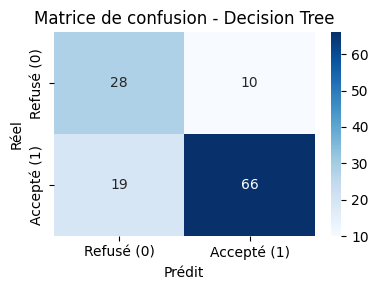

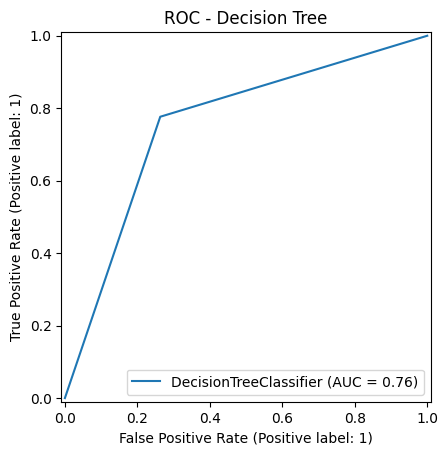

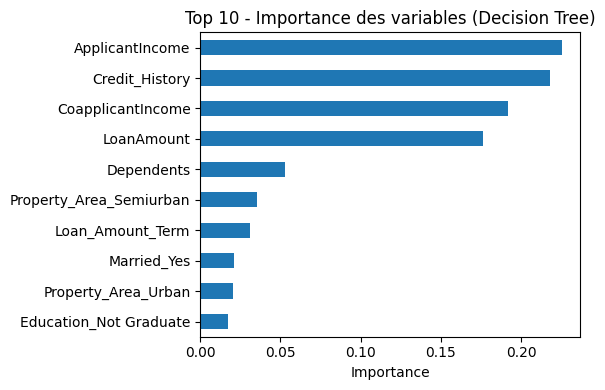

In [11]:
# 1) Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Refusé (0)", "Accepté (1)"],
            yticklabels=["Refusé (0)", "Accepté (1)"])
plt.title("Matrice de confusion - Decision Tree")
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.tight_layout(); plt.show()

# 2) Courbe ROC
RocCurveDisplay.from_estimator(dt, X_test, y_test)
plt.title("ROC - Decision Tree"); plt.show()

# 3) Importance des variables (top 10)
importances = pd.Series(dt.feature_importances_, index=X_train.columns)
imp_top = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(6,4))
imp_top.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 - Importance des variables (Decision Tree)")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()

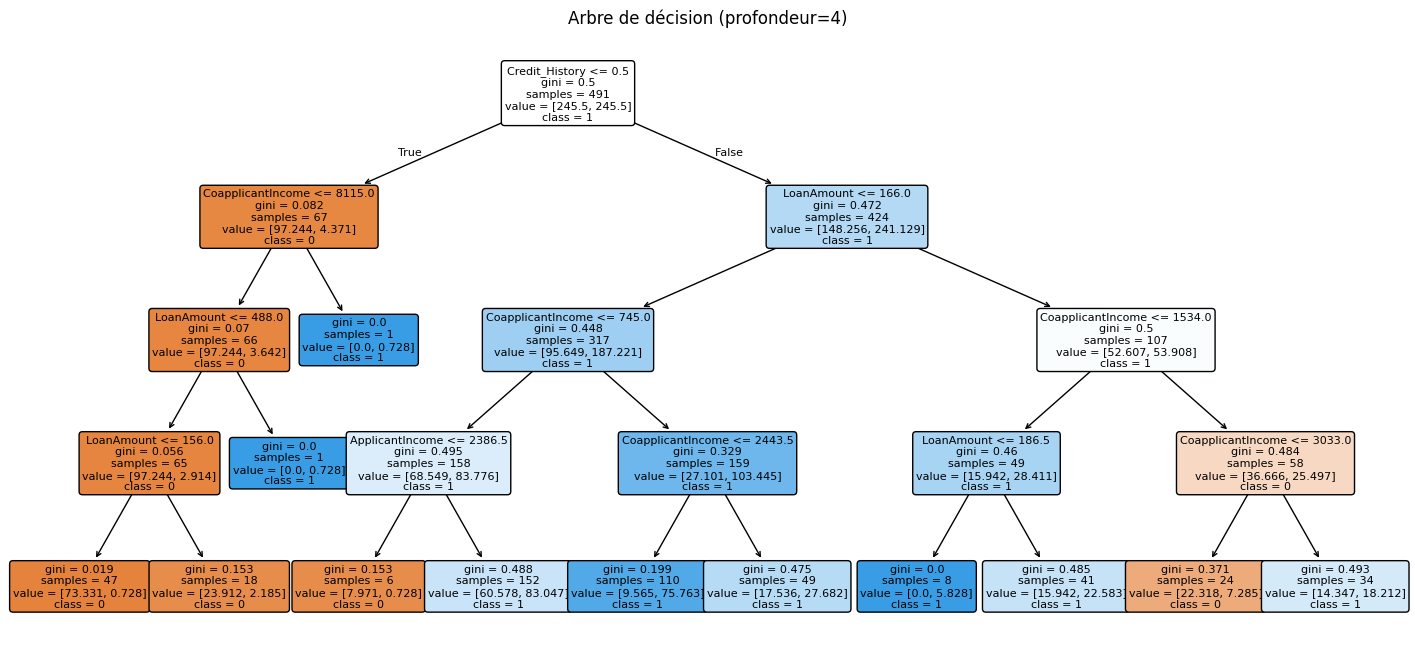

In [12]:
# Attention: utile seulement si l'arbre est peu profond (ex. max_depth<=4)
small_dt = DecisionTreeClassifier(max_depth=4, class_weight="balanced", random_state=42)
small_dt.fit(X_train, y_train)

plt.figure(figsize=(18,8))
plot_tree(small_dt, feature_names=X_train.columns, class_names=["0","1"],
          filled=True, rounded=True, fontsize=8)
plt.title("Arbre de décision (profondeur=4)")
plt.show()


### B. Random Forest